# Imports

In [ ]:
!pip install -q jupyternotify
!pip install -q tensorflow_text
!pip install -q tqdm
!pip install -q wandb --upgrade
!pip install flopco-keras

In [ ]:
# standart liberies:
from typing import Optional, List, Set, Dict, Tuple
import datetime
import os
import csv
import random
import statistics
import math
import time
import sys
from functools import lru_cache, reduce
# NOT-standart liberies:
from flopco_keras import FlopCoKeras  # flop counter for keras at https://github.com/evgps/flopco-keras
import wandb
import platform
import tensorflow as tf
import tensorflow_text as tf_text
import pandas as pd
import seaborn as sns
import numpy as np
import tqdm
import matplotlib.pyplot as plt
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [ ]:
print(f"Python version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")
print(f"tf text version: {tf_text.__version__}")

Python version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Tensorflow version: 2.9.1
tf text version: 2.9.0


In [ ]:
print('GPU info:')
!nvidia-smi

GPU info:
Thu Jul  7 13:15:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                              

# Settings

In [ ]:
tf.random.set_seed(0)
random.seed(0)
# tf.keras.backend.set_floatx('float16')

In [ ]:
device: str
if 'google.colab' in sys.modules:
    device = 'colab'
else:
    device = 'locally'
curr_folder = os.getcwd()

## Define a strategy - Accelerator optimization 

In [ ]:
%%capture
# disable printing
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver();
    tf.config.experimental_connect_to_cluster(resolver);
    tf.tpu.experimental.initialize_tpu_system(resolver);
    strategy = tf.distribute.TPUStrategy(resolver);
    using_tpu: bool = True;
except ValueError:
    print("You must connect to a TPU in order to train a model. The models dont fit in a colab GPU")
    exit()

# Data loading

In [ ]:
if device == 'colab':  # If notebook is ran on colab
    from google.colab import drive
    drive.mount('/drive')
    df: pd.DataFrame = pd.read_csv('/drive/MyDrive/final_project/wikipedia_articles.csv')
else:  # If notebook is ran on my laptop
    df: pd.DataFrame = pd.read_csv('wiki_data/articles.csv')
print(df.shape)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
(30279, 2)


In [ ]:
df: pd.Series = df['text']
data_list: List[str] = df.to_list()
DATA_SIZE = len(data_list)
print(f"There are {DATA_SIZE} data points")
string_lengths: List[int] = [len(data_point) for data_point in data_list]
max_string_len = max(string_lengths)
print(f"The length of the longest text IN CHARACTERS is: {max_string_len}")
min_string_len = min(string_lengths)
print(f"The length of the shortest text IN CHARACTERS is: {min_string_len}")

There are 30279 data points
The length of the longest text IN CHARACTERS is: 141803
The length of the shortest text IN CHARACTERS is: 816


## Creating the vocabulary

In [ ]:
# %%time
bert_tokenizer_params: dict = dict(lower_case=True)
VOCAB_SIZE: int = 8192  # Always the same for all models

if device == 'colab':  # If notebook is ran on colab
    path = '/drive/MyDrive/final_project/vocab.txt'
else:  # If notebook is ran on my laptop
    path = 'C:/yoni/final_project/model/vocab.txt'


reserved_tokens: List[str] = ["[PAD]", "[UNK]", "[START]", "[END]", "[MASK]"]

if os.path.exists(path):
    with open(path, 'r') as f:
        vocab: List[str] = f.read().split()
else:
    bert_vocab_args: dict = dict(
        # The target vocabulary size
        vocab_size = VOCAB_SIZE,
        # Reserved tokens that must be included in the vocabulary
        reserved_tokens=reserved_tokens,
        # Arguments for `tf_text.BertTokenizer`
        bert_tokenizer_params=bert_tokenizer_params,
        # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
        learn_params={},
    )
    tensor_list: list = [tf.convert_to_tensor(data_point) for data_point in data_list]
    data_set: tf.data.Dataset = tf.data.Dataset.from_tensor_slices(tensor_list)
    # I already ran this code and saved the file to C:/yoni/final_project/model/vocab.txt
    vocab: List[str] = tf_text.bert_vocab_from_dataset.bert_vocab_from_dataset(
        data_set,
        **bert_vocab_args,)
    with open('C:/yoni/final_project/model/vocab.txt', 'w') as f:
        for token in vocab:
            f.write(token + ' ')

In [ ]:
print(f"the type of the items in vocab: {type(vocab[0])}")
print(f"the first 15 items in vocab: {vocab[:15]}")
print(f" the length of vocab: {len(vocab)}")

the type of the items in vocab: <class 'str'>
the first 15 items in vocab: ['[PAD]', '[UNK]', '[START]', '[END]', '[MASK]', "'", ',', '.', '0', '1', '2', '3', '4', '5', '6']
 the length of vocab: 7882


In [ ]:
tensor_vocab: List[tf.Tensor] = [tf.convert_to_tensor(token_key, dtype=tf.string) for token_key in vocab]  # dtype = tf.String
print(f" the type of the items in tensor_vocab is: {type(tensor_vocab[0])}")
print(f" the data type of the tensors in tensor_vocab is: {tensor_vocab[0].dtype}")
vocab_size = len(vocab)

 the type of the items in tensor_vocab is: <class 'tensorflow.python.framework.ops.EagerTensor'>
 the data type of the tensors in tensor_vocab is: <dtype: 'string'>


## Creating the tokenizer

In [ ]:
lookup_table = tf.lookup.StaticVocabularyTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=tensor_vocab,
        key_dtype=tf.string,
        values=tf.range(tf.size(vocab, out_type=tf.int64), dtype=tf.int64),
        value_dtype=tf.int64),
    num_oov_buckets=1
)
tokenizer = tf_text.BertTokenizer(lookup_table, **bert_tokenizer_params)

## Tokenizing the data

In [ ]:
# START: int = tf.argmax(tf.constant(reserved_tokens) == "[START]")  # The value of the start token
# END: int = tf.argmax(tf.constant(reserved_tokens) == "[END]")  # The value of the end token
# starts = tf.cast(tf.Variable([START]), dtype = tf.int32)  # Tensor of shape [1] and dtype int
# ends = tf.cast(tf.Variable([END]), dtype = tf.int32)  # Tensor of shape [1] and dtype int
starts = tf.constant([2], dtype=tf.int32)
ends = tf.constant([3], dtype=tf.int32)
pad_int: int = int(tf.argmax(tf.constant(reserved_tokens) == "[PAD]"))
pad_ten: tf.TensorSpec(dtype=tf.int32, shape=()) = tf.constant([pad_int], dtype=tf.int32)

In [ ]:
def tokenize_string(text: str) -> tf.Tensor:
    """Converts string to tensor"""
    ragged: tf.RaggedTensor = tokenizer.tokenize(text)[0, :]
    eager: tf.Tensor = ragged.to_tensor(default_value=0, shape=[None, 1])  # 0 is the value of the padding token
    sqeezed: tf.Tensor = tf.squeeze(eager, axis=1)
    typed: tf.Tensor = tf.cast(sqeezed, tf.int32)
    edited: tf.Tensor = tf.concat([starts, typed, ends], axis=0)
    return edited

In [ ]:
tokenized_data: List[tf.Tensor] = [tokenize_string(data_point) for data_point in data_list] 

# tqdm is a progress bar

In [ ]:
print(len(tokenized_data))
print(tokenized_data[0].shape)
print(tokenized_data[0][:10])

30279
(670,)
tf.Tensor([   2 1011 7670   57   18 6423  617   33   61   44], shape=(10,), dtype=int32)


25315
178


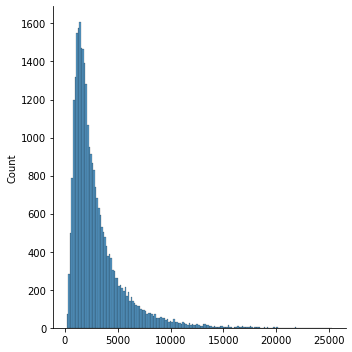

In [ ]:
lengths_tokenized: List[int] = [text.shape[0] for text in tokenized_data]
print(max(lengths_tokenized))
print(min(lengths_tokenized))
sns.displot(lengths_tokenized);

### chunk too long texts

In [ ]:
max_seq_len: int = 256
def chunk_tensor(tensor: tf.Tensor, max_len: int = max_seq_len) -> List[tf.Tensor]:
    """Splits 1d tensor to chunks (1d tensors) of maximum size: max_len"""
    return [tensor[i*max_len:(i+1)*max_len] for i in range(tensor.shape[0] // max_len)]

In [ ]:
chunked_data: List[tf.Tensor] = []
for tensor in tokenized_data:
    chunks = chunk_tensor(tensor, max_seq_len)
    for chunk in chunks:
        chunked_data.append(chunk)
DATA_SIZE: int = len(chunked_data)
print(DATA_SIZE)
print(chunked_data[0].shape)

336056
(256,)


## Padding

In [ ]:
def pad(tensor: tf.Tensor, pad_int: int) -> tf.Tensor:
    """Pads the tensor to the length of the longest text in the data set"""
    padded: tf.Tensor = tf.pad(tensor=tensor, paddings=[[pad_int, max_seq_len - tensor.shape[0]]], mode='CONSTANT', constant_values=0)
    # 0 is the padding token
    return padded

In [ ]:
padded_data: List[tf.Tensor] = [pad(text, pad_int) for text in chunked_data]
chunked_data.sort(key = lambda t: t.shape[0])  # sorting so that every batch will have similar sized texts

## Train test val split

In [ ]:
batch_size: int = 128 if using_tpu else 32

def list_to_dataset(tokenized_list: List[tf.Tensor]) -> tf.data.Dataset:
    """Converts a list of tokenized texts after all preprocessing to a tf.data.Dataset"""
    dataset: tf.data.Dataset = tf.data.Dataset.from_tensor_slices(tokenized_list)
    batched: tf.data.Dataset = dataset.batch(batch_size)
    return batched

batched_data_ten = list_to_dataset(padded_data)
batched_data_list = list(batched_data_ten)
random.shuffle(batched_data_list)
if batched_data_list[-1].shape[0] != batch_size:
    batched_data_list = batched_data_list[:-1]
data_size = len(batched_data_list)
train_size: int = int(data_size * 0.8) 
val_test_size: int = int(data_size * 0.1)  # Both validation and test get 10% of the data
list_train_set: List[tf.Tensor] = batched_data_list[:train_size]
list_val_set: List[tf.Tensor] = batched_data_list[train_size:(train_size + val_test_size)]
list_test_set: List[tf.Tensor] = batched_data_list[(train_size + val_test_size)]

## Clear memory

In [ ]:
del batched_data_list, train_size, val_test_size, data_size
del padded_data, chunked_data, tokenized_data, data_list, df, lengths_tokenized
del lookup_table, reserved_tokens
del bert_tokenizer_params, ends, starts, vocab, tensor_vocab
del chunk, chunks

# Model


## Positional encoding

The formula for calculating the positional encoding is as follows:

$${PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$${PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

where $d_{model}$ is the model dimension, $pos$ is the position and $i$ is the index of the embedding.
this is taken from the paper: attention is all you need.

In [ ]:
def create_positional_encoding(max_len: int, d_model: int) -> tf.Tensor:
    """Returns the positional encoding for a given a maximal sequence length and model dimension.
    inputs: max_len: int, d_model: int
    returns: tf.Tensor of shape (1, max_len, d_model) and dtype tf.keras.backend.floatx()
    The 1 is for the batch dimension, the place in the batch dimension does not matter"""

    def get_angles(positions: np.ndarray, timestamps: np.ndarray, d_model: int) -> np.ndarray:
        """Returns the angle in radians for given positions, timestamps and the dimension of the model
        input: positions: np.ndarray of shape (max_len, 1), timestamps: np.ndarray of shape (1, d_model), d_model: int
        output: np.ndarray of shape (max_len, d_model)"""
        if tf.keras.backend.floatx() == "float32":
            angle_rates = 1 / np.power(10000, ((2 * (timestamps//2)) / np.float32(d_model)))
        else:
            angle_rates = 1 / np.power(10000, ((2 * (timestamps//2)) / np.float16(d_model)))

        return positions * angle_rates
    
    angle_rads = get_angles(np.arange(max_len)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)  # (max_len, d_model)

    # apply sin to even indices in the array; 2i for i in range(d_model // 2)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # (max_len, d_model)

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # (max_len, d_model)

    pos_encode = angle_rads[np.newaxis, ...]  # (1, max_len, d_model)

    return tf.cast(pos_encode, dtype=tf.keras.backend.floatx())

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third token, only the first and second token will be used. Similarly to predict the fourth token, only the first, second and the third tokens will be used and so on.

In [ ]:
def create_masks(inp: tf.Tensor, tar: tf.Tensor, pad_ten: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        """Creates all the masks needed for the model
        input: inp: tf.Tensor of shape (batch_size, seq_len), tar: tf.Tensor of shape (batch_size, set_size)
        Returns: tuple of (padding_mask, look_ahead_mask)
        padding_mask, look_ahead_mask: tf.Tensor of shape (batch_size, 1, 1, seq_len)"""
        
        def create_padding_mask(seq: tf.Tensor) -> tf.Tensor:
                """Returns a padding mask for the given sequence.
                input: seq: tf.Tensor of shape (batch_size, seq_len)
                Returns: tf.Tensor of shape (batch_size, 1, 1, seq_len)"""
                seq = tf.cast(tf.math.equal(seq, pad_ten), tf.keras.backend.floatx())  
                # For every item in the sequence, 1 if it is a padding token, 0 if it is not 

                # add extra dimensions to add the padding
                
                return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)
        
        # Encoder padding mask
        padding_mask: tf.Tensor = create_padding_mask(inp)  # (batch_size, 1, 1, seq_len)

        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        set_size: int = tar.shape[1]

        def create_look_ahead_mask(set_size: int) -> tf.Tensor:
                mask = 1 - tf.linalg.band_part(tf.ones((set_size, set_size)), -1, 0)
                mask = tf.cast(mask, dtype=tf.keras.backend.floatx())
                return mask  # (seq_len, seq_len)

        look_ahead_mask = create_look_ahead_mask(set_size)  # (seq_len, seq_len)
        dec_target_padding_mask = create_padding_mask(tar)  # (batch_size, 1, 1, seq_len)
        look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask) # (batch_size, 1, 1, seq_len)

        return padding_mask, look_ahead_mask

## Layers and blocks

In [ ]:
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, d_model: int, **kwargs):
        super().__init__(**kwargs)
        self.scale: tf.TensorSpec(shape=(), dtype=tf.keras.backend.floatx())
        # scale = 1 / sqrt(d_model)
        self.scale = tf.math.pow(tf.cast(d_model, tf.keras.backend.floatx()), -0.5)
        self.softmax = tf.keras.layers.Softmax(axis=-1)

    def call(self, q: tf.Tensor, k: tf.Tensor, v: tf.Tensor, mask: Optional[tf.Tensor] = None) -> tf.Tensor:
        """Scaled Dot-Product Attention
        input: 
        q: tf.Tensor of shape (batch_size, seq_len, d_model), 
        k: tf.Tensor of shape (batch_size, seq_len, d_model), 
        v: tf.Tensor of shape (batch_size, seq_len, d_model), 
        mask: Optional[tf.Tensor] of shape (batch_size, 1, 1, seq_len)
        output: tf.Tensor of shape (batch_size, seq_len, d_model)"""
        matmul_qk: tf.Tensor = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

        # Scaled Dot-Product Attention
        scaled_attention_logits: tf.Tensor = matmul_qk * self.scale  # (..., seq_len_q, seq_len_k)
        # matmul_qk / sqrt(d_model)

        # Masking
        if mask is not None:
            # noinspection PyTypeChecker
            if tf.keras.backend.floatx() == 'float16':
                # tf.float16.min is minus infinity
                scaled_attention_logits += (mask * tf.float16.min)  # changed from -1e9 to prevent nan's
            else:
                scaled_attention_logits += (mask * -1e9) 

        # Normalize
        attention_weights = self.softmax(scaled_attention_logits)
        # (..., seq_len_q, seq_len_k)

        # Output
        output = tf.matmul(attention_weights, v)

        return output

In [ ]:
class MyMultiHeadAttention(tf.keras.layers.Layer):
    """U can use the built-in tf.keras.layers.multihead_attention but is caused a bug for me"""
    def __init__(self, num_heads: int, d_model: int, **kwargs):
        super().__init__(**kwargs)
        if d_model % num_heads != 0:
            raise ValueError(f"d_model ({d_model}) must be divisible by num_heads ({num_heads})")
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        self.sdpa = ScaledDotProductAttention(d_model)

    def split_heads(self, x: tf.Tensor, batch_size: int) -> tf.Tensor:
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v_k: tf.Tensor, q: tf.Tensor, mask: tf.Tensor) -> tf.Tensor:
        """inputs:
        v_k: tf.Tensor of shape (batch_size, seq_len, d_model) in self attention keys and values are the same
        q: tf.Tensor of shape (batch_size, seq_len, d_model)
        mask: Optional[tf.Tensor] of shape (batch_size, seq_len)"""
        batch_size = tf.shape(q)[0]

        q: tf.Tensor = self.wq(q)  # (batch_size, seq_len, d_model)
        k: tf.Tensor = self.wk(v_k)  # (batch_size, seq_len, d_model)
        v: tf.Tensor = self.wv(v_k)  # (batch_size, seq_len, d_model)

        q: tf.Tensor = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k: tf.Tensor = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v: tf.Tensor = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape should be (batch_size, num_heads, seq_len_q, depth)
        scaled_attention = self.sdpa(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) 
         # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
          # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output

In [ ]:
class PointWiseFeedForwardNetwork(tf.keras.layers.Layer):
    def __init__(self, d_model: int, dff: int, **kwargs): 
        super().__init__(**kwargs)
        self.layer1 = tf.keras.layers.Dense(dff, activation='relu')  # (batch_size, seq_len, dff)
        self.layer2 = tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """Gets tensor of shape (batch_size, seq_len, d_model) and dtype tf.keras.beckend.floatx()
        Returns tensor of shape (batch_size, seq_len, d_model) and dtype tf.keras.beckend.floatx()"""
        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [ ]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model: int, num_heads: int, dff: int, drop_out_rate: float, **kwargs):
        super().__init__(**kwargs)

        self.mha = MyMultiHeadAttention(num_heads = num_heads, d_model = d_model)
        self.ffn = PointWiseFeedForwardNetwork(d_model, dff)

        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(drop_out_rate)

    def call(self, x: tf.Tensor, training: bool, mask: tf.Tensor) -> tf.Tensor:
        
        attn_output = self.mha(x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout(attn_output, training=training)  # (batch_size, input_seq_len, d_model)
        # out1 = self.layer_norm(x + attn_output)  # (batch_size, input_seq_len, d_model)
        # might be data leak
        out1 = self.layer_norm(attn_output)  # (batch_size, input_seq_len, d_model)
        
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout(ffn_output, training=training)  # (batch_size, input_seq_len, d_model)
        out2 = self.layer_norm(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [ ]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model: int, num_heads: int, dff: int, rate: float, **kwargs):
        super().__init__(**kwargs)

        self.mha = MyMultiHeadAttention(num_heads = num_heads, d_model = d_model)

        self.ffn = PointWiseFeedForwardNetwork(d_model, dff)

        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x: tf.Tensor, enc_output: tf.Tensor, look_ahead_mask: tf.Tensor, padding_mask: tf.Tensor, training):
        # enc_output.shape should be (batch_size, input_seq_len, d_model)

        attn1 = self.mha(x, x, look_ahead_mask)  # (batch_size, set_size, d_model)
        attn1 = self.dropout(attn1, training=training)  # (batch_size, set_size, d_model)
        # out1 = self.layer_norm(attn1 + x)
        # might be data leak
        out1 = self.layer_norm(attn1)  # (batch_size, set_size, d_model)

        attn2 = self.mha(enc_output, out1, padding_mask)  # (batch_size, set_size, d_model)
        attn2 = self.dropout(attn2, training=training)  # (batch_size, set_size, d_model)
        out2 = self.layer_norm(attn2 + out1)  # (batch_size, set_size, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, set_size, d_model)
        ffn_output = self.dropout(ffn_output, training=training)
        out3 = self.layer_norm(ffn_output + out2)  # (batch_size, set_size, d_model)

        return out3 

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, pos_encoding: tf.Tensor, num_blocks: int, d_model: int, num_heads: int, dff: int, rate=0.1, **kwargs):
        super().__init__(**kwargs)

        self.d_model = d_model
        self.num_blocks = num_blocks
        self.pos_encoding = pos_encoding

        self.enc_blocks = [EncoderBlock(d_model, num_heads, dff, rate) for _ in range(num_blocks)]
        # the encoder 
        self.dropout = tf.keras.layers.Dropout(rate)
        self.scale = tf.math.sqrt(tf.cast(self.d_model, tf.keras.backend.floatx()))

    def call(self, x: tf.Tensor, training, mask: tf.Tensor) -> tf.Tensor:

        seq_len = tf.shape(x)[1]

        # adding position encoding.
        # assert not tf.math.is_nan(x[0][0][0])
        x *= self.scale
        # assert not tf.math.is_nan(x[0][0][0])
        
        x += self.pos_encoding[:, :seq_len, :]  # (batch_size, input_seq_len, d_model)
        # assert not tf.math.is_nan(x[0][0][0])
        x = self.dropout(x, training=training)  # (batch_size, input_seq_len, d_model)
        # assert not tf.math.is_nan(x[0][0][0])

        for i in range(self.num_blocks):
            x = self.enc_blocks[i](x, training, mask)  # (batch_size, input_seq_len, d_model)
            # assert not tf.math.is_nan(x[0][0][0])

        return x  # (batch_size, input_seq_len, d_model)  

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, pos_encoding, num_blocks: int, d_model: int, num_heads: int, dff: int,
                 vocab_size: int, rate: float, **kwargs):
        super().__init__(**kwargs)

        self.scale = tf.math.sqrt(tf.cast(d_model, tf.keras.backend.floatx()))
        self.num_blocks = num_blocks
        self.pos_encoding = pos_encoding

        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.dec_layers = [DecoderBlock(d_model, num_heads, dff, rate) for _ in range(num_blocks)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, tar: tf.Tensor, enc_output: tf.Tensor, training: bool,
             look_ahead_mask: tf.Tensor, padding_mask: tf.Tensor) -> tf.Tensor:

        seq_len = tf.shape(tar)[1]

        x = self.embedding(tar)  # (batch_size, set_size, d_model)
        x *= self.scale
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_blocks):
            x = self.dec_layers[i](x=x, enc_output=enc_output, look_ahead_mask=look_ahead_mask, 
                                   padding_mask=padding_mask, training=training)

        # x.shape should be (batch_size, set_size, d_model)
        return x

In [ ]:
class EmbeddingTransposed(tf.keras.layers.Layer):
    def __init__(self, tied_to: tf.keras.layers.Embedding = None, activation: Optional[str] = None, **kwargs):
        super(EmbeddingTransposed, self).__init__(**kwargs)
        self.tied_to = tied_to
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.custom_weights = self.tied_to.weights[0]
        self.built = True

    def compute_output_shape(self, input_shape):
        return input_shape[0], tf.keras.backend.int_shape(self.tied_to.weights[0])[0]

    def call(self, inputs, mask=None):
        output = tf.keras.backend.dot(inputs, tf.keras.backend.transpose(self.custom_weights))
        if self.activation is not None:
            output = self.activation(output)
        return output

    def get_config(self):
        config = {"activation": tf.keras.activations.serialize(self.activation)}
        base_config = super(EmbeddingTransposed, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## The full model

In [ ]:
class SeTransformer(tf.keras.Model):
    """The base architecture of my models in this project."""
    def __init__(self, num_blocks: int, d_model: int, num_heads: int, dff: int,
                 vocab_size: int, max_len: int, rate: float, pad_int: int, using_tpu: bool, **kwargs):
        super().__init__(**kwargs)  # calls tf.keras.Model's __init__ method
        self.pad_int = pad_int
        self.vocab_size = vocab_size
        pos_encoding = create_positional_encoding(max_len, d_model)
        self.d_model = d_model

        self.encoder = Encoder(pos_encoding, num_blocks, d_model, num_heads, dff, rate)
        self.decoder = Decoder(pos_encoding, num_blocks, d_model, num_heads, dff, vocab_size, rate)

        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=d_model)
        self.emb_trans = EmbeddingTransposed(self.embedding, "softmax")
        # self.dense = tf.keras.layers.Dense(vocab_size, activation="softmax")


    def count_params(self) -> int:
        """counts trainable parameters
        Raises an error if caleed before building the model"""
        param_count: int = self.encoder.count_params() + self.decoder.count_params() + self.embedding.count_params() + self.emb_trans.count_params()
        assert isinstance(param_count, int)
        return param_count


    def call(self, inputs: list, training: bool) -> tf.Tensor:
        inp, tar = inputs
        # inp.shape should be (batch_size, max_seq_len)
        # tar.shape should be (batch_size, set_size)
        x = self.embedding(inp)  # (batch_size, max_seq_len, d_model)
        # for d0 in range(x.shape[0]):
        #     for d1 in range(x.shape[1]):
        #         for d2 in range(x.shape[2]):
        #             assert not tf.math.is_nan(x[d0][d1][d2])
        # if len(x.shape) == 3:
        #     assert not tf.math.is_nan(x[0][0][0])
        # elif len(x.shape) == 2:
        #     assert not tf.math.is_nan(x[0][0])
        # else: raise ValueError('embedding output should by 3 dim tensor')
        padding_mask, look_ahead_mask = create_masks(inp, tar, self.pad_int)
        
        enc_output = self.encoder(x, training, padding_mask)  # (batch_size, max_seq_len, d_model)
        # assert not tf.math.is_nan(enc_output[0][0][0])

        # dec_output.shape should be (batch_size, set_size, d_model)
        dec_output = self.decoder(tar, enc_output, training, look_ahead_mask, padding_mask)
        # assert not tf.math.is_nan(dec_output[0][0][0])

        final_output = self.emb_trans(dec_output)
        # assert not tf.math.is_nan(final_output[0][0][0])
        return final_output

In [ ]:
sample_transformer = SeTransformer(
    num_blocks=2, d_model=32, num_heads=4, dff=128,
    vocab_size=7000,
    max_len=1200, pad_int=0, rate=0.1, using_tpu=False)

temp_input = tf.random.uniform((1, 200), dtype=tf.int32, minval=5, maxval=6999)
temp_target = tf.random.uniform((1, 8), dtype=tf.int32, minval=5, maxval=6999)
temp_target2 = temp_target + 3

train_out = sample_transformer([temp_input, temp_target], training=True)
train_out2 = sample_transformer([temp_input, temp_target2], training=True)

try:
    tf.debugging.assert_equal(train_out, train_out2)
except tf.errors.InvalidArgumentError:
    print("WARNING: model output depends on the target")

non_train_out = sample_transformer([temp_input, temp_target], training=False)
print(f"The attribuites of the model are: {dir(sample_transformer)}")

del sample_transformer, train_out, non_train_out, temp_target2, train_out2

tf.Tensor(
[[[1.15601404e-04 1.00934602e-04 1.55265472e-04 ... 1.62815239e-04
   1.59162548e-04 1.23081874e-04]
  [1.09918677e-04 1.05700725e-04 1.45990314e-04 ... 1.52201581e-04
   1.42956109e-04 1.32665285e-04]
  [9.97192910e-05 1.18472752e-04 1.44033955e-04 ... 1.62413868e-04
   1.32923684e-04 1.48421663e-04]
  ...
  [9.47656445e-05 1.21456826e-04 1.57714909e-04 ... 1.65316000e-04
   1.45888436e-04 1.40580785e-04]
  [1.05273932e-04 1.18380987e-04 1.60773139e-04 ... 1.61111850e-04
   1.36885632e-04 1.36959861e-04]
  [1.11600384e-04 1.10392466e-04 1.62879311e-04 ... 1.62439799e-04
   1.35497758e-04 1.25011953e-04]]], shape=(1, 8, 7000), dtype=float32)
tf.Tensor(
[[[9.09473965e-05 1.16539813e-04 1.35742303e-04 ... 1.65404737e-04
   1.38030431e-04 1.50942520e-04]
  [9.98887626e-05 1.10046654e-04 1.33460926e-04 ... 1.60958094e-04
   1.41049357e-04 1.48143139e-04]
  [1.04687300e-04 1.10940069e-04 1.21875091e-04 ... 1.57932300e-04
   1.37086812e-04 1.60027557e-04]
  ...
  [1.00436497e-04 1

# Training the model

## Hyper-Parameters

In [ ]:
set_size: int = 2
learning_rate: float = 0.01

num_sets: int = (max_seq_len // set_size) - 1 # Because we dont predict the first set
# number of sets in each sequence

num_blocks: int = 8
d_model: int = 256
dff: int = 512
num_heads: int = 16
dropout_rate: float = 0.1

## Create the model

In [ ]:
with strategy.scope():
    model = SeTransformer(
        num_blocks=num_blocks,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        vocab_size=vocab_size,
        max_len=max_seq_len,
        rate=dropout_rate,
        pad_int=pad_int,
        using_tpu=using_tpu)
    
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = tf.keras.optimizers.Adam(learning_rate, epsilon=tf.keras.backend.epsilon())
    temp_input = tf.random.uniform((batch_size, max_seq_len), dtype=tf.int32, minval=5, maxval=6999)
    temp_target = tf.random.uniform((batch_size, set_size), dtype=tf.int32, minval=5, maxval=6999)
    model.compile(optimizer=optimizer, loss=loss_func)

param_count: int = model.count_params()
print(f"The model has {param_count:,} = {param_count * (10**-6):,}M trainable parameters")
stats = FlopCoKeras(model)
flops_per_call: int = stats.total_flops
macs_per_call: int = stats.total_macs

# (add-multiplies per forward pass) * (2 FLOPs/add-multiply) * (3 for forward and backward pass) * (number of examples in dataset) 
training_flops: float  = macs_per_call * 2 * flops_per_call / macs_per_call * (3 * train_step_calles + val_step_calles)
print(f"FLOPs per call: {flops_per_call:,} = {(flops_per_call * (10 ** -6)):,}M")
print(f"MACs per call: {macs_per_call:,} = {(macs_per_call * (10 ** -6)):,}M")

del temp_input, temp_target

The model has 4,084,480 trainable parameters


## Weights and Biases

In [ ]:
%wandb login
%notify('waiting for user input')
# my API key is 58def12d67e682fb2c89ab27e91e612243568aba

In [ ]:
run = wandb.init(
    project="pytorch-intro",
    entity="yoniteam",
    name=datetime.datetime.today().strftime(f"run from %d/%m/%Y"),
    settings=wandb.Settings(start_method="thread"),
    config = {"set size": set_size,
              "batch size": batch_size,
              "learning rate": learning_rate,
              "max seq len": max_seq_len,
              "num blocks": num_blocks,
              "model dimention": d_model,
              "dff": dff,
              "num heads": num_heads,
              "dropout rate": dropout_rate,
              "params": param_count
              })
config = wandb.config

wandb: Currently logged in as: yonikremer (yoniteam). Use `wandb login --relogin` to force relogin


## Training helper functions

In [ ]:
@tf.function
def contains_pad(inp: tf.Tensor):
    bool_ten = tf.math.equal(inp, pad_ten)
    nonzero_count = tf.math.count_nonzero(bool_ten)
    return nonzero_count > 0

### Train

In [ ]:
@tf.function(input_signature=(tf.TensorSpec(shape=[batch_size, None], dtype=tf.int32),
                              tf.TensorSpec(shape=[batch_size, set_size], dtype=tf.int32)))
def train_step(inp: tf.Tensor, outp: tf.Tensor) -> tf.Tensor:
    with tf.GradientTape() as tape:
        pred: tf.Tensor = model([inp, outp], training=True) 
        loss_val: tf.Tensor = loss_func(y_true = outp, y_pred = pred)
    grads: tf.RaggedTensor = tape.gradient(loss_val, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return tf.math.reduce_mean(loss_val)

In [ ]:
@tf.autograph.experimental.do_not_convert
@tf.function(input_signature=[tf.TensorSpec(shape=[batch_size, max_seq_len], dtype=tf.int32)])
def train(batch: tf.Tensor) -> tf.TensorSpec(shape=[], dtype=tf.keras.backend.floatx()):
    per_generation_loss: tf.Tensor = tf.zeros([num_sets], dtype=tf.keras.backend.floatx())
    i = 0
    while i < num_sets:
        # The input is of size set_size-TAKE_TO_ACCOUNT
        already_predicted: int = i * (set_size + 1)
        start_from: int = max(0, already_predicted - max_seq_len)
        inp: tf.Tensor = batch[:, start_from:(i + 1) * set_size]
        have_pad = tf.map_fn(contains_pad, inp, fn_output_signature=tf.bool, parallel_iterations=batch_size)
        if tf.get_static_value(tf.math.reduce_all(have_pad)):
            break
        outp: tf.TensorSpec(shape=[batch_size, set_size]) = batch[:, (i + 1) * set_size:(i + 2) * set_size]
        loss_val: tf.TensorSpec(shape=[], dtype=tf.keras.backend.floatx()) = train_step(inp, outp)
        one_hot: tf.TensorSpec(shape=[num_sets], dtype=tf.keras.backend.floatx())
        one_hot = tf.one_hot([i], num_sets, dtype=tf.keras.backend.floatx()) * loss_val
        per_generation_loss += one_hot
        i += 1
    train_step_calles += i 
    return tf.math.reduce_mean(per_generation_loss[:i])
    

### Validate

In [ ]:
@tf.function(input_signature=(tf.TensorSpec(shape=[batch_size, None], dtype=tf.int32),
                                  tf.TensorSpec(shape=[batch_size, set_size], dtype=tf.int32)))
def val_step(inp: tf.Tensor, outp: tf.Tensor) -> tf.Tensor:
    pred = model([inp, outp], training=False)
    loss_val = loss_func(y_true = outp, y_pred = pred)
    return tf.math.reduce_mean(loss_val)

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(shape=[batch_size, max_seq_len], dtype=tf.int32)])
def validate(batch: tf.Tensor) -> tf.TensorSpec(shape=[], dtype=tf.keras.backend.floatx()):
    per_generation_loss: tf.Tensor = tf.zeros([num_sets], dtype=tf.keras.backend.floatx())
    i = 0
    while i < num_sets:
        # The input is of size set_size-TAKE_TO_ACCOUNT
        already_predicted: int = i * (set_size + 1)
        start_from: int = max(0, already_predicted - max_seq_len)
        inp: tf.Tensor = batch[:, start_from:(i + 1) * set_size]
        have_pad = tf.map_fn(contains_pad, inp, fn_output_signature=tf.bool, parallel_iterations=batch_size)
        if tf.get_static_value(tf.math.reduce_all(have_pad)):
            break
        outp: tf.TensorSpec(shape=[batch_size, set_size]) = batch[:, (i + 1) * set_size:(i + 2) * set_size]
        loss_val: tf.TensorSpec(shape=[], dtype=tf.keras.backend.floatx()) = val_step(inp, outp)
        one_hot: tf.TensorSpec(shape=[num_sets], dtype=tf.keras.backend.floatx())
        one_hot = tf.one_hot([i], num_sets, dtype=tf.keras.backend.floatx()) * loss_val
        per_generation_loss += one_hot
        i += 1
    val_step_calles += i
    return tf.math.reduce_mean(per_generation_loss[:i])

## Chackpoints

In [ ]:
date: str = datetime.datetime.now().strftime('%m%d-%H%M')
if device == 'colab':
    folder_path: str = "/drive/MyDrive/final_project/checkpoints/"
else:
    folder_path: str = "C:/yoni/final_project/model/checkpoints/"
check_points_path = f"{folder_path}{date}"
if not os.path.isdir(folder_path):
    os.mkdir(folder_path)
if not os.path.isdir(check_points_path):
    os.mkdir(check_points_path)

In [ ]:
def check_point(folder_path: str, model: SeTransformer, val_loss: float, train_loss: float, test_loss = None):
    """Saves the model at the end of each epoch"""
    # (add-multiplies per forward pass) * (2 FLOPs/add-multiply) * 
    # * (3 for forward and backward pass) * (number of examples in dataset) 
    num_ops: float  = macs_per_call * 2 * flops_per_call / macs_per_call * (3 * train_step_calles + val_step_calles)
    peta_ops: float = num_ops * (10 ** (-15))
    tf.keras.models.save_model(model = model, filepath = folder_path, save_format='tf', overwrite=True)
    artifact = wandb.Artifact('new_artifact', type='my_model', description = f"the model after {num_ops:,} operations")
    artifact.add_dir(f'after_{training_flops:,}_ops/')
    run.log_artifact(artifact)
    print("Saved checkpoint")
    %notify("Saved checkpoint")

In [ ]:
train_loss, val_loss = float('inf'), float('inf')
best_val_loss = float('inf')

In [ ]:
def loss_to_prob(loss: float) -> float:
    return math.exp(-loss)

## The actual training loop!

In [ ]:
def train_loop():
    epochs: int = 1000000  # Train until the cloud disconnects or the model stops improving
    per_epoch_train_loss: List[float] = []
    per_epoch_val_loss: List[float] = []
    print(f"number of train batches per epoch: {len(list_train_set)}")
    last_save_time = time.time()
    global epoch: int = 0
    global batch_num: int = 0
    global val_step_calles: int = 0
    global train_step_calles: int = 0
    for epoch in range(epochs):
        print(f"epoch number: {epoch}")
        per_batch_train_loss: List[float] = []
        per_batch_val_loss: List[float] = []
        for batch_num in tqdm.tqdm(range(len(list_train_set))):  # tqdm is a progress bar
            train_loss: tf.Tensor = train(list_train_set[batch_num])
            float_val_loss = tf.keras.backend.eval(train_loss).item()
            per_batch_train_loss.append(train_loss)
            if batch_num % 8 == 0:  # 8 is number of training batches/number of val batches
                # because training set is 80% of the data and val set is 10%
                next_val_batch: tf.Tensor = list_val_set[batch_num // 8]
                val_loss: tf.Tensor = validate(next_val_batch)
                float_val_loss = tf.keras.backend.eval(val_loss).item()
                per_batch_val_loss.append(val_loss)
                wandb.log({"epoch": epoch, "batch": batch_num, "per batch train loss": train_loss, 
                        "per batch val loss": val_loss})
                if time.time() - last_save_time > 3600.0 and val_loss < math.log(vocab_size):  
                    # If the last save is more than a hour (3600 sec) ago
                    # and if the predictions are not random
                    check_point(check_points_path, model, per_epoch_val_loss[-1], per_epoch_train_loss[-1])
                    last_save_time = time.time()
                elif train_loss < 0.01:
                    title: str = "Over fitting or data leak"
                    message = f"Training loss is {train_loss} and val loss is {val_loss} in the latest batch"
                    wandb.alert(title=title, text=message)
                    print(title)
                    print(message)
                    %notify(title)
                    return train_loss, val_loss
                elif time.time() - last_save_time > 1800.0 and val_loss >= math.log(vocab_size):
                    # if the prob of every token is 1/vocab_size, the loss is
                    # -ln(1/vocab_size) = ln(vocab_size) 
                    # by the logrithem rule log(a^x)=xlog(a) where x = -1
                    # if after 30 mins of training, the model predictions are still random
                    title: str = "Under fitting"
                    message = f"training loss is {train_loss} and val loss is {val_loss} in the latest batch"
                    wandb.alert(title=title, text=message)
                    print(title)
                    print(message)
                    %notify(title)
                    return train_loss, val_loss
        per_epoch_train_loss.append(statistics.mean(per_batch_train_loss))
        per_epoch_val_loss.append(statistics.mean(per_batch_val_loss))
        print(f"train_loss: {per_epoch_train_loss[-1]}")
        print(f"prob of right ans train: {loss_to_prob(per_epoch_train_loss[-1])}")
        print(f"val_loss: {per_epoch_val_loss[-1]}")
        print(f"prob of right ans val: {loss_to_prob(per_epoch_val_loss[-1])}")
        if len(per_epoch_val_loss) > 1:
            if per_epoch_val_loss[-1] >= per_epoch_val_loss[-2]:
                print("Validation loss increased. Stopped training")
                %notify("Validation loss increased. Stopped training")
                return per_epoch_train_loss[-1], per_epoch_val_loss[-1]
        check_point(check_points_path, model, per_epoch_val_loss[-1], per_epoch_train_loss[-1])
        last_save_time = time.time()
        print("Saved checkpoint")
        %notify("Epoche ended, Saved checkpoint")

In [ ]:
with strategy.scope():
    train_loss, val_loss = train_loop()

number of train batches per epoch: 8401
epoch number: 0


  0%|          | 0/8401 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'fscope' is not defined
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'fscope' is not defined
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


reproduce error

In [ ]:
import tensorflow as tf
resolver = tf.distribute.cluster_resolver.TPUClusterResolver();
tf.config.experimental_connect_to_cluster(resolver);
tf.tpu.experimental.initialize_tpu_system(resolver);
strategy = tf.distribute.TPUStrategy(resolver);

In [ ]:
with strategy.scope():
    exm_model = tf.keras.Sequential([
        tf.keras.layers.Dense(2, activation="relu", name="layer1"),
        tf.keras.layers.Dense(3, activation="relu", name="layer2"),
        tf.keras.layers.Dense(1, name="layer3"),
    ])
    exm_optimizer = tf.keras.optimizers.Adam()
    mse = tf.keras.losses.MeanSquaredError()

@tf.function(input_signature=(tf.TensorSpec(shape=[3,3], dtype=tf.int32),
                              tf.TensorSpec(shape=[3], dtype=tf.int32)))
def exm_train_step(inp: tf.Tensor, outp: tf.Tensor) -> tf.Tensor:
    with tf.GradientTape() as tape:
        pred: tf.Tensor = exm_model(inp) 
        loss_val: tf.Tensor = mse(outp, pred)
    grads: tf.RaggedTensor = tape.gradient(loss_val, model.trainable_weights)
    exm_optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return tf.math.reduce_mean(loss_val)


exm_inp = tf.random.uniform(shape=[3, 3], dtype=tf.int32, maxval=100, minval=0)
exm_out = tf.random.uniform(shape=[3], dtype=tf.int32, maxval=100, minval=0)


exm_train_step(exm_inp, exm_out)

## After training

In [ ]:
test_loss = statistics.mean([validate(test_batch) for test_batch in tqdm.tqdm(list_test_set)])
print(f"Test loss: {test_loss}")
check_point(check_points_path, model, val_loss, train_loss, test_loss)